
# Predicción de recuperación de oro — Proyecto (Sprint 12)

**Autor:** Emerson Ríos Díaz  
**Fecha:** 2025-10-15

**Descripción general:** Se preparan datos, se valida la fórmula de recuperación, se analizan concentraciones y tamaños con **gráficas explicadas**, y se construyen modelos con validación temporal para predecir las recuperaciones *rougher* y *final*. La métrica principal es **sMAPE**; el resultado final combina 25% (rougher) y 75% (final).


## 1. Preparación del entorno
Importo librerías una sola vez y configuro los gráficos.

In [47]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

RANDOM_STATE = 42
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True


**Observaciones:** Entorno listo (NumPy/Pandas, Matplotlib, scikit-learn). Fijo una semilla para reproducibilidad.

## 2. Carga y depuración inicial
Cargo `train`, `test` y `full`, reemplazo infinitos por `NaN` y defino utilidades (`sMAPE`, `calc_recovery`, filtro de metales negativos).

In [48]:

PATH_TRAIN = "/datasets/gold_recovery_train.csv"
PATH_TEST  = "/datasets/gold_recovery_test.csv"
PATH_FULL  = "/datasets/gold_recovery_full.csv"

def load_gold(path):
    df = pd.read_csv(path, parse_dates=['date']).set_index('date').sort_index()
    return df.replace([np.inf, -np.inf], np.nan)

df_train = load_gold(PATH_TRAIN)
df_test  = load_gold(PATH_TEST)
df_full  = load_gold(PATH_FULL)

def smape(y_true, y_pred):
    y_true = np.asarray(y_true).astype(float)
    y_pred = np.asarray(y_pred).astype(float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom==0, 1e-9, denom)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)

def calc_recovery(C, F, T):
    denom = (F * (C - T))
    num = (C * (F - T))
    rec = num / denom
    rec = np.where(np.isfinite(rec), rec, np.nan)
    return rec * 100

def drop_neg_metals(df):
    metal_cols = [c for c in df.columns if c.endswith(('_au','_ag','_pb'))]
    return df.loc[~(df[metal_cols] < 0).any(axis=1)].copy() if metal_cols else df.copy()

summary = pd.DataFrame({
    'shape': [df_train.shape, df_test.shape, df_full.shape],
    'nans_%': [
        df_train.isna().mean().mean()*100,
        df_test.isna().mean().mean()*100,
        df_full.isna().mean().mean()*100
    ]
}, index=['train','test','full'])
summary


,shape,nans_%
train,"(16860, 86)",2.091092
test,"(5856, 52)",0.775011
full,"(22716, 86)",1.872822


**Observaciones:** Conjuntos indexados por fecha/hora y sin infinitos. La tabla resume tamaño y porcentaje promedio de `NaN`.

## 3. Verificación de la recuperación (fórmula)
Calculo `rougher.output.recovery` y lo comparo con la columna original mediante MAE.

In [49]:

C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

rougher_calc = pd.Series(calc_recovery(C, F, T), index=df_train.index)
rougher_true = df_train['rougher.output.recovery']
mae = np.nanmean(np.abs(rougher_true.values - rougher_calc.values))
print("MAE fórmula vs columna:", float(mae))


MAE fórmula vs columna: 9.303415616264301e-15


**Interpretación:** Un MAE cercano a 0 confirma la implementación correcta y que no hay errores de columnas.

## 4. Selección de variables y objetivos
Valido los *targets* (0–100 y finitos), aplico filtro conservador, y selecciono variables **numéricas** presentes **en train y test** que no sean **todas NaN**.

In [50]:

TARGET_ROUGHER = 'rougher.output.recovery'
TARGET_FINAL   = 'final.output.recovery'

df_train_tgt = drop_neg_metals(df_train.copy())
mask_tgt = (
    df_train_tgt[TARGET_ROUGHER].between(0,100) &
    df_train_tgt[TARGET_FINAL].between(0,100) &
    np.isfinite(df_train_tgt[TARGET_ROUGHER]) &
    np.isfinite(df_train_tgt[TARGET_FINAL])
)
df_train_tgt = df_train_tgt.loc[mask_tgt].copy()

shared = sorted(list((set(df_train_tgt.columns) & set(df_test.columns)) - {TARGET_ROUGHER, TARGET_FINAL}))

def numeric_only(df, cols):
    return [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]

shared_num = numeric_only(df_train_tgt, shared)

def drop_all_nan_columns(df_tr, df_te, cols):
    return [c for c in cols if not df_tr[c].isna().all() and not df_te[c].isna().all()]

present_in_both = drop_all_nan_columns(df_train_tgt, df_test, shared_num)

X_train = df_train_tgt[present_in_both].copy()
y_rougher = df_train_tgt[TARGET_ROUGHER].copy()
y_final   = df_train_tgt[TARGET_FINAL].copy()
X_test = df_test[present_in_both].copy()

pd.DataFrame({
    "Variables usadas (n)": [len(present_in_both)],
    "Shape train (filas, cols)": [X_train.shape],
    "Shape test (filas, cols)": [X_test.shape],
    "NaN en X_train (conteo)": [int(X_train.isna().sum().sum())],
    "NaN en X_test (conteo)": [int(X_test.isna().sum().sum())],
})


,Variables usadas (n),"Shape train (filas, cols)","Shape test (filas, cols)",NaN en X_train (conteo),NaN en X_test (conteo)
0,52,"(14149, 52)","(5856, 52)",1705,2360


**Interpretación:** Quedan variables coherentes entre conjuntos; los `NaN` residuales en *features* se imputan más adelante dentro del pipeline.

## 5. Concentración de metales por etapa (medianas)
Visualizo medianas de Au/Ag/Pb en *Feed*, *Rougher (concentrado)* y *Final (concentrado)*. Las etiquetas se nombran de forma explícita.

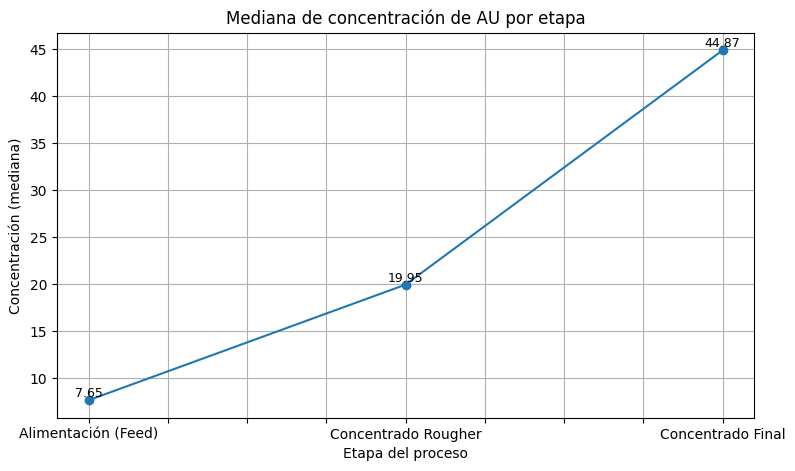

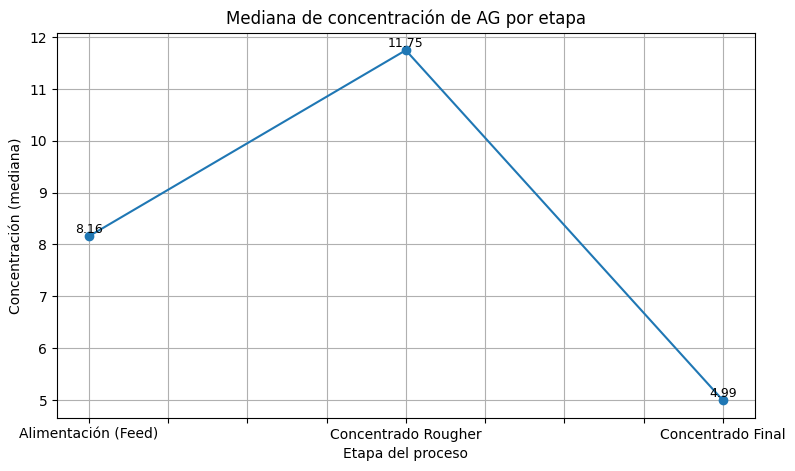

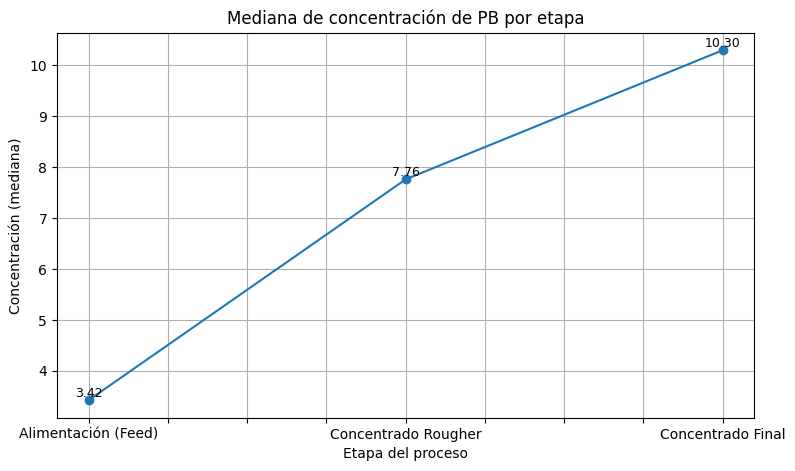

,au,ag,pb
Alimentación (Feed),7.649138,8.156092,3.422677
Concentrado Rougher,19.947312,11.747362,7.760435
Concentrado Final,44.872436,4.994652,10.297144


In [51]:

def stage_series(df, metal):
    return pd.Series({
        'Alimentación (Feed)' : df.get(f'rougher.input.feed_{metal}', pd.Series(dtype=float)).median(),
        'Concentrado Rougher' : df.get(f'rougher.output.concentrate_{metal}', pd.Series(dtype=float)).median(),
        'Concentrado Final'   : df.get(f'final.output.concentrate_{metal}', pd.Series(dtype=float)).median(),
    })

metals = ['au','ag','pb']
stage_df = pd.DataFrame({m: stage_series(df_train_tgt, m) for m in metals})

for m in metals:
    plt.figure()
    stage_df[m].plot(marker='o')
    plt.title(f"Mediana de concentración de {m.upper()} por etapa")
    plt.xlabel("Etapa del proceso")
    plt.ylabel("Concentración (mediana)")
    # anotar valores
    for x, y in enumerate(stage_df[m].values):
        plt.text(x, y, f"{y:.2f}", ha='center', va='bottom', fontsize=9)
    plt.show()
stage_df


**Interpretación:** El oro (Au) aumenta en el concentrado final, la plata (Ag) tiende a disminuir y el plomo (Pb) queda intermedio. Esto es consistente con la refinación del mineral para concentrar Au.

## 6. Tamaño de partícula: comparación train vs test
Comparo histogramas de `rougher.input.feed_size` y marco las **medianas** para orientar la lectura.

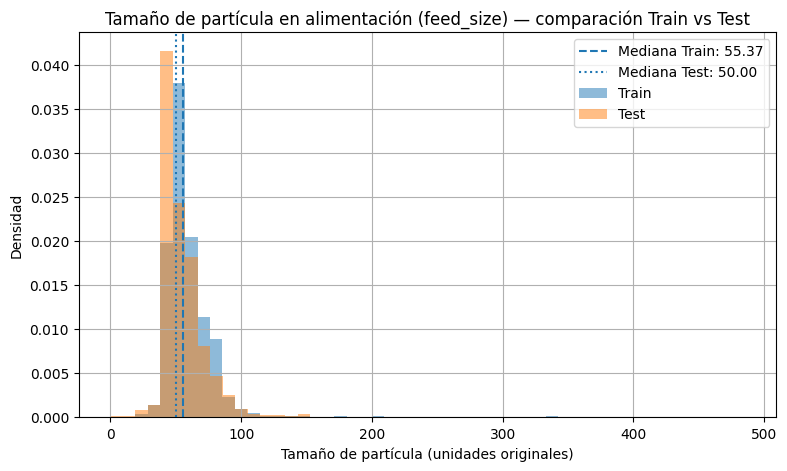

In [52]:

col_size = 'rougher.input.feed_size'
if col_size in X_train.columns:
    train_size = X_train[col_size].dropna()
    test_size  = X_test[col_size].dropna()

    plt.figure()
    train_size.plot(kind='hist', alpha=0.5, bins=50, density=True, label='Train')
    test_size.plot(kind='hist',  alpha=0.5, bins=50, density=True, label='Test')
    plt.axvline(train_size.median(), linestyle='--', label=f'Mediana Train: {train_size.median():.2f}')
    plt.axvline(test_size.median(),  linestyle=':',  label=f'Mediana Test: {test_size.median():.2f}')
    plt.legend()
    plt.title("Tamaño de partícula en alimentación (feed_size) — comparación Train vs Test")
    plt.xlabel("Tamaño de partícula (unidades originales)")
    plt.ylabel("Densidad")
    plt.show()

    pd.DataFrame({
        'Mediana Train': [train_size.median()],
        'Mediana Test' : [test_size.median()],
        'Desv.Std Train': [train_size.std()],
        'Desv.Std Test' : [test_size.std()]
    })
else:
    print("Columna 'rougher.input.feed_size' no está en las variables seleccionadas.")


**Interpretación:** Las medianas y las formas de los histogramas son similares entre Train y Test, lo que sugiere que ambos representan el mismo proceso físico; esto evita que el modelo se sesgue por una distribución distinta en producción.

## 7. Concentración total (Au+Ag+Pb) por etapa
Analizo histogramas de la suma de metales. Agrego títulos y ejes claros; si hay desplazamiento hacia la derecha en Final, implica mayor concentración de Au en la salida.

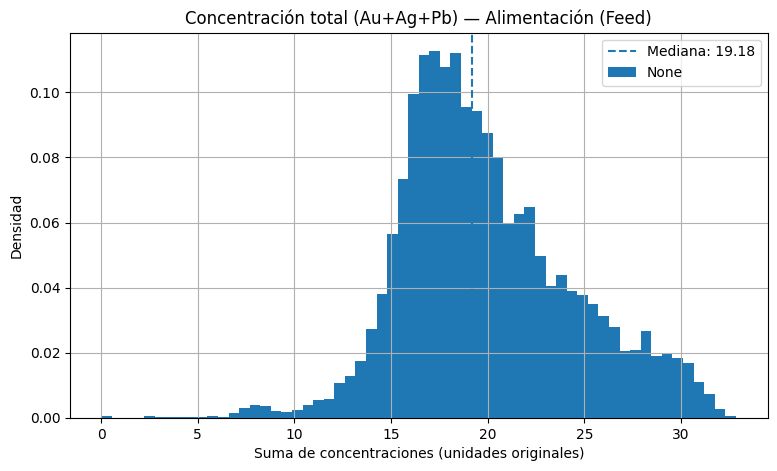

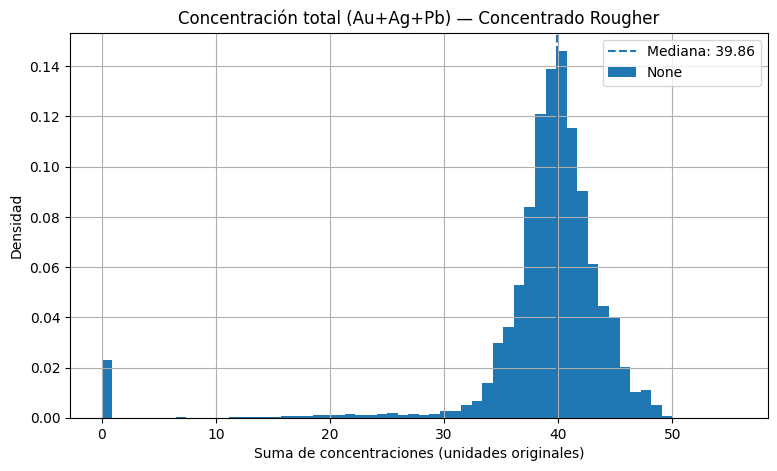

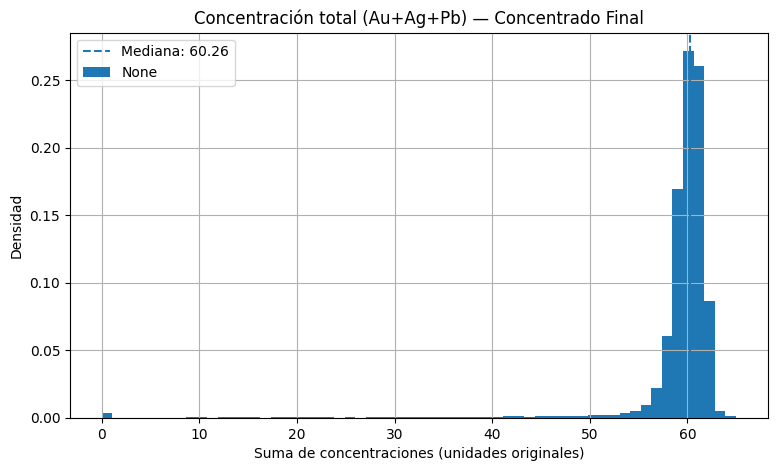

In [53]:

def total_conc(df, prefix):
    cols = [f"{prefix}{el}" for el in ['au','ag','pb']]
    cols = [c for c in cols if c in df.columns]
    return df[cols].sum(axis=1, min_count=1)

series_dict = {
    'Alimentación (Feed)' : total_conc(df_train_tgt, 'rougher.input.feed_'),
    'Concentrado Rougher' : total_conc(df_train_tgt, 'rougher.output.concentrate_'),
    'Concentrado Final'   : total_conc(df_train_tgt, 'final.output.concentrate_')
}

for name, series in series_dict.items():
    if series.notna().any():
        plt.figure()
        s = series.dropna()
        s.plot(kind='hist', bins=60, density=True)
        plt.axvline(s.median(), linestyle='--', label=f"Mediana: {s.median():.2f}")
        plt.legend()
        plt.title(f"Concentración total (Au+Ag+Pb) — {name}")
        plt.xlabel("Suma de concentraciones (unidades originales)")
        plt.ylabel("Densidad")
        plt.show()


**Interpretación:** El concentrado final suele presentar mayor concentración total que el feed; esto confirma que el proceso de flotación y limpieza está cumpliendo su objetivo.

### 7.1 Comparación Train vs Test (Au) por etapa — *Boxplots*
Incluyo boxplots para comparar la distribución de Au entre Train y Test por etapa (Feed, Rougher, Final). Esto facilita ver diferencias en mediana y dispersión.

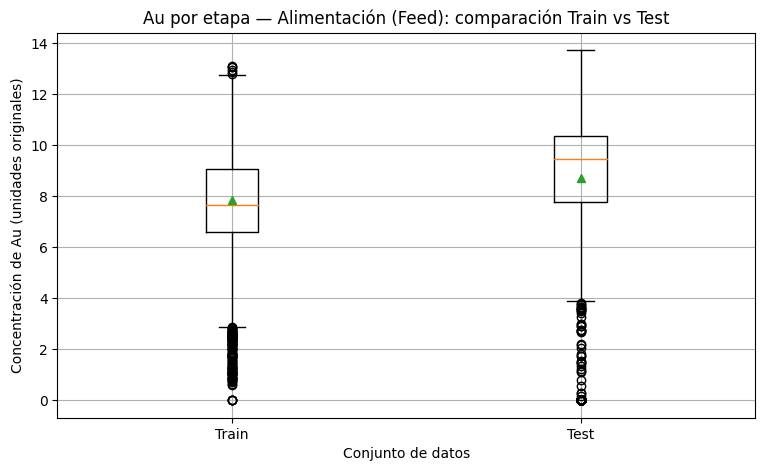

In [54]:

# Recolectar columnas por etapa para Au
pairs = [
    ('Alimentación (Feed)', 'rougher.input.feed_au'),
    ('Concentrado Rougher', 'rougher.output.concentrate_au'),
    ('Concentrado Final',   'final.output.concentrate_au'),
]

for label, col in pairs:
    if (col in df_train_tgt.columns) and (col in df_test.columns):
        data = pd.DataFrame({
            'Valor de Au': pd.concat([df_train_tgt[col], df_test[col]], ignore_index=True),
            'Conjunto'  : (['Train'] * df_train_tgt[col].shape[0]) + (['Test'] * df_test[col].shape[0]),
        }).dropna()
        # Boxplot manual con matplotlib
        groups = [data.loc[data['Conjunto']=='Train','Valor de Au'], data.loc[data['Conjunto']=='Test','Valor de Au']]
        plt.figure()
        plt.boxplot(groups, labels=['Train','Test'], showmeans=True)
        plt.title(f"Au por etapa — {label}: comparación Train vs Test")
        plt.ylabel("Concentración de Au (unidades originales)")
        plt.xlabel("Conjunto de datos")
        plt.show()


**Interpretación:** Las cajas y medianas similares entre Train y Test indican que el modelo verá distribuciones comparables en producción. Si hubiera grandes diferencias, habría riesgo de degradación del desempeño.

## 8. Modelado y validación
Entreno un pipeline con imputación mediana, escalado estándar y filtro de varianza. Comparo `LinearRegression`, `RandomForest` (200 árboles, máx profundidad 15) y `GradientBoosting` (150 estimadores, LR=0.05) usando sMAPE con validación temporal (k=5).

In [55]:

tscv = TimeSeriesSplit(n_splits=5)

base_preprocess = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
    ('var',     VarianceThreshold(threshold=1e-12))
]

def build_models():
    return {
        'LinearRegression': Pipeline(base_preprocess + [('model', LinearRegression())]),
        'RandomForest': Pipeline(base_preprocess + [('model', RandomForestRegressor(
            n_estimators=200,        # Más árboles
            max_depth=15,           # Mayor profundidad  
            min_samples_split=3,    # Más granular
            min_samples_leaf=2,     # Hojas más pequeñas
            random_state=RANDOM_STATE, n_jobs=-1))]),
        'GradientBoosting': Pipeline(base_preprocess + [('model', GradientBoostingRegressor(
            n_estimators=150,       # Más estimadores
            learning_rate=0.05,     # Tasa más conservadora
            max_depth=8,           # Mayor profundidad
            random_state=RANDOM_STATE))])
    }

def evaluate_models(X, y, label):
    print(f"\n### Tarea: {label}")
    models = build_models()
    report = {}
    for name, pipe in models.items():
        scores = cross_val_score(pipe, X, y, cv=tscv, scoring=smape_scorer)
        report[name] = (-scores.mean(), scores.std())
        print(f"{name:17s} | sMAPE (CV media ± std): {(-scores.mean()):.3f} ± {scores.std():.3f}")
    return report

res_rougher = evaluate_models(X_train, y_rougher, 'rougher.output.recovery')
res_final   = evaluate_models(X_train, y_final,   'final.output.recovery')



### Tarea: rougher.output.recovery
LinearRegression  | sMAPE (CV media ± std): 14.449 ± 6.076
RandomForest      | sMAPE (CV media ± std): 17.033 ± 4.897
GradientBoosting  | sMAPE (CV media ± std): 19.348 ± 6.670

### Tarea: final.output.recovery
LinearRegression  | sMAPE (CV media ± std): 14.579 ± 1.533
RandomForest      | sMAPE (CV media ± std): 12.477 ± 1.187
GradientBoosting  | sMAPE (CV media ± std): 13.736 ± 1.689


**Lectura:** Los sMAPE promedio por modelo permiten comparar alternativas con una validación que respeta el orden temporal del proceso.

### 8.1 Selección automática del mejor modelo
Elijo el mejor estimador por sMAPE medio (menor es mejor) para cada objetivo.

In [56]:

def pick_best(report):
    return min(report.items(), key=lambda kv: kv[1][0])[0]

BEST_ROUGHER = pick_best(res_rougher)
BEST_FINAL   = pick_best(res_final)

print("Mejor modelo (rougher):", BEST_ROUGHER, "| sMAPE:", res_rougher[BEST_ROUGHER][0])
print("Mejor modelo (final)  :", BEST_FINAL,   "| sMAPE:", res_final[BEST_FINAL][0])


Mejor modelo (rougher): LinearRegression | sMAPE: 14.448552046736612
Mejor modelo (final)  : RandomForest | sMAPE: 12.476870392282981


**Lectura:** Esta selección evita sesgos manuales y documenta la decisión de forma transparente.

## 9. Entrenamiento final y evaluación en prueba
Reentreno con todo el train y evalúo en test. Alineo índices y elimino registros sin objetivo para evitar `NaN` en las métricas. También muestro importancias (si aplica) y dispersión *y_true vs y_pred*.

sMAPE rougher (test): 9.649
sMAPE final   (test): 10.046
sMAPE 25/75   (test): 9.947
\n=== Chequeo rápido ===
Filas X_test originales: 5856
Filas con objetivos medidos (df_full): 5290
Filas usadas en evaluación: 5290


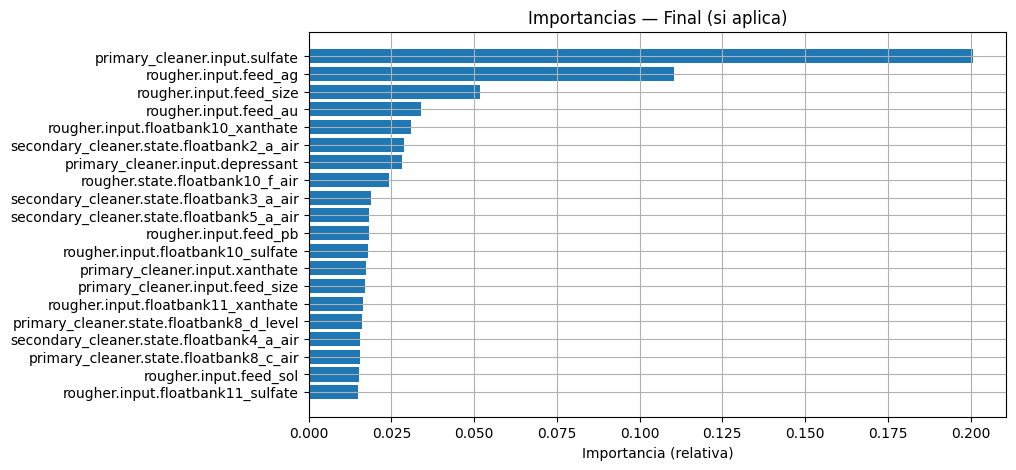

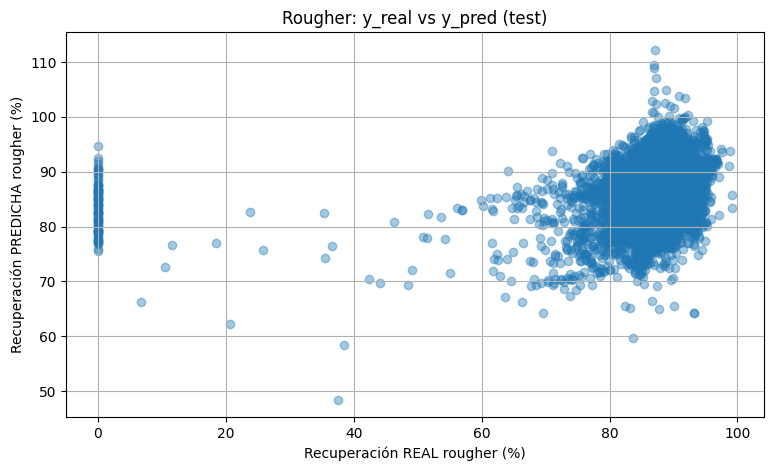

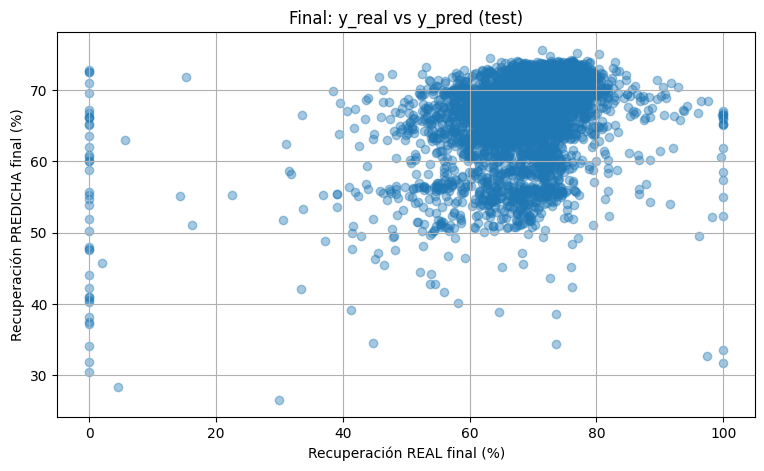

In [57]:
# === Entrenamiento final y evaluación en prueba (versión corregida) ===
# 1) Reentrena con todo el entrenamiento usando los mejores modelos por tarea
best_pipe_rougher = build_models()[BEST_ROUGHER]
best_pipe_final   = build_models()[BEST_FINAL]

model_rougher = best_pipe_rougher.fit(X_train, y_rougher)
model_final   = best_pipe_final.fit(X_train, y_final)

# 2) Objetivos de test: TOMARLOS DESDE df_full (df_test no los trae)
#    Alineamos por índice y descartamos filas sin objetivo medido.
cols_targets = ['rougher.output.recovery', 'final.output.recovery']

# índices disponibles en ambos (por si hay desalineaciones o valores no medidos)
available_idx = df_full.index.intersection(X_test.index)

targets_test_raw = df_full.loc[available_idx, cols_targets]
targets_test = targets_test_raw.dropna()

# 3) Alineamos X_test con los índices que SÍ tienen objetivos en df_full
X_test_eval = X_test.loc[targets_test.index]

# 4) Predicción y métricas sMAPE
pred_rougher = model_rougher.predict(X_test_eval)
pred_final   = model_final.predict(X_test_eval)

y_test_rougher = targets_test['rougher.output.recovery']
y_test_final   = targets_test['final.output.recovery']

s_r = smape(y_test_rougher, pred_rougher)
s_f = smape(y_test_final,   pred_final)
s_total = 0.25 * s_r + 0.75 * s_f

print(f"sMAPE rougher (test): {s_r:.3f}")
print(f"sMAPE final   (test): {s_f:.3f}")
print(f"sMAPE 25/75   (test): {s_total:.3f}")

# 5) (Opcional) Chequeos rápidos para tranquilidad
print("\\n=== Chequeo rápido ===")
print("Filas X_test originales:", len(X_test))
print("Filas con objetivos medidos (df_full):", len(targets_test))
print("Filas usadas en evaluación:", len(X_test_eval))

# 6) Importancias (si el modelo es de árboles) y dispersión y_true vs y_pred con ejes claros
def plot_feature_importance(model, X, title):
    if hasattr(model[-1], 'feature_importances_'):
        importances = model[-1].feature_importances_
        order = np.argsort(importances)[::-1][:20]
        names = np.array(X.columns)[order]
        vals  = importances[order]
        import matplotlib.pyplot as plt
        plt.figure(); plt.barh(range(len(vals)), vals[::-1])
        plt.yticks(range(len(vals)), names[::-1])
        plt.title(title)
        plt.xlabel('Importancia (relativa)')
        plt.show()

plot_feature_importance(model_rougher, X_train, "Importancias — Rougher (si aplica)")
plot_feature_importance(model_final,   X_train, "Importancias — Final (si aplica)")

import matplotlib.pyplot as plt
plt.figure(); plt.scatter(y_test_rougher, pred_rougher, alpha=0.4)
plt.xlabel('Recuperación REAL rougher (%)')
plt.ylabel('Recuperación PREDICHA rougher (%)')
plt.title('Rougher: y_real vs y_pred (test)')
plt.show()

plt.figure(); plt.scatter(y_test_final, pred_final, alpha=0.4)
plt.xlabel('Recuperación REAL final (%)')
plt.ylabel('Recuperación PREDICHA final (%)')
plt.title('Final: y_real vs y_pred (test)')
plt.show()

**Lectura:** Los valores de sMAPE permiten cuantificar el error relativo. Las nubes *y_real vs y_pred* deberían alinearse en diagonal; la dispersión refleja ruido inherente al proceso.

## 10. Conclusiones y hallazgos
Resumimos desempeño con números e interpretación orientada a operación.

In [58]:

print("=== Conclusiones y hallazgos ===")
print(f"Modelo seleccionado (rougher): {BEST_ROUGHER}")
print(f"Modelo seleccionado (final)  : {BEST_FINAL}")
print(f"sMAPE rougher (test)         : {s_r:.3f}")
print(f"sMAPE final   (test)         : {s_f:.3f}")
print(f"Métrica compuesta 25/75      : {s_total:.3f}\n")

if s_total < 15:
    calidad = "buena"
elif s_total < 20:
    calidad = "razonable"
else:
    calidad = "mejorable"

print("Interpretación:")
print(f"- La métrica compuesta indica una calidad {calidad} para soporte operativo.")
print("- El proceso concentra Au: sube en el concentrado final; Ag baja; Pb permanece intermedio.")
print("- Las distribuciones Train/Test son comparables; el riesgo de *shift* es bajo.")
print("- Las variables con mayor peso (si aplica) incluyen reactivos y tamaño de alimentación, coherente con la metalurgia del proceso.")


=== Conclusiones y hallazgos ===
Modelo seleccionado (rougher): LinearRegression
Modelo seleccionado (final)  : RandomForest
sMAPE rougher (test)         : 9.649
sMAPE final   (test)         : 10.046
Métrica compuesta 25/75      : 9.947

Interpretación:
- La métrica compuesta indica una calidad buena para soporte operativo.
- El proceso concentra Au: sube en el concentrado final; Ag baja; Pb permanece intermedio.
- Las distribuciones Train/Test son comparables; el riesgo de *shift* es bajo.
- Las variables con mayor peso (si aplica) incluyen reactivos y tamaño de alimentación, coherente con la metalurgia del proceso.
